# 給食の献立提案(前半) - 量子アニーリングソリューションコンテスト

## 概要
2021/12/19に行われた[量子アニーリングソリューションコンテスト](http://www.tfc.tohoku.ac.jp/special/qca/20211218.html)に、T-QARD-949として参加しました。  
残念ながら入賞は出来ませんでしたが、多くの方に動画を見て頂けて嬉しかったです。その動画はこちらからご覧出来ます。

<iframe width="560" height="315" src="https://www.youtube.com/embed/BqTC-FUMWc8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

本記事では、動画では説明しきれなかった実装部分に重点を当てて解説していきます。

## 問題

給食は栄養バランスの他にも、多くの制約を考慮して作られています。

![問題](figures/fig1.png)

これらの制約をすべて満たす献立を毎月作成するのはかなり大変です。実際、給食の献立作成時間について次のようなデータがあります。

|    |  人数  |　平均±標準偏差(時間/週)　|
| ---- | :---: | :---: |
| 管理栄養士  | 20  |　8.0±6.5 |
|  栄養士 | 26 |　7.7±6.6 |

[参考資料]
[給食施設における献立作成業務実態調査　-作業の所要時間と標準化に向けて- / 大中佳子　他](https://core.ac.uk/download/pdf/230128196.pdf)

このように、献立作成には週8時間ほどの作業時間が必要です。我々が提案するアプリケーションでは、この時間を大幅に改善できると考えます。

## ソリューション

我々は、アプリ名をCoQ(Combination of C(Q)ooking)さんと名付けました。ここでは、CoQさんの全体像を示します。

![全体像](figures/fig2.png)

### 献立データの学習

ボルツマン機械学習を用いて、給食の献立を学習する方法について説明します。

![ボルツマン機械学習](figures/fig3.png)

QUBO行列をD-Waveマシンに入力すると、ギブス・ボルツマン分布に近い解候補が出力されます。その出力結果を用いて、献立データの経験分布にギブス・ボルツマン分布が近づくようにQUBO行列(ボルツマンマシンのパラメータ)を更新し、この操作を繰り返します。

最後に学習済みのQUBO行列を用いて、食材の組み合わせをサンプリングします。

本記事は[こちら](https://colab.research.google.com/gist/mohzeki222/9693bf93bf10c9966a123d89554baa1a/chapter4.ipynb)のコードを参考にしています。学習方法についてよりくわしく知りたい方はご覧ください。

### 献立の提案

自己組織化マップについては、次の記事で詳しく解説するため省略します。本記事では、ボルツマン機械学習の部分を解説します。

## 実験

まず、必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install tqdm
!pip install dwave-ocean-sdk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### データセットの準備

我々は、仙台市が公開している給食の献立を対象に実験を行いました。献立は[こちら](http://www.city.sendai.jp/kyushokune/kurashi/manabu/kyoiku/inkai/kanren/kyushoku/kyushoku/kongetsu.html)で確認できます。

* 「使う食材とその調理方法」 → 1
* 「使わない食材」 → 0

として、献立データのCSVファイルを作成しました。

In [ ]:
!wget "https://raw.githubusercontent.com/T-QARD/t-wave/main/notebooks/CoQ/school_lunch_sendai.csv"

In [7]:
df_data = pd.read_csv("school_lunch_sendai.csv")
df_data = df_data.iloc[:, 1:]
D = df_data.values.astype(np.int8)
df_data.head()

,焼く,炒める,揚げる,煮る,生,焼く.1,炒める.1,揚げる.1,和える,煮る.1,...,きゅうり,キャベツ,とうもろこし,たまねぎ,えだまめ,きくらげ,グリンピース,じゃがいも,さつまいも,はるさめ
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0


In [4]:
N, M = D.shape
print(f'データの数 N: {N}, 食材の数 M: {M}')

データの数 N: 24, 食材の数 M: 79


### 定式化

罰金項は次の４つです。


1.   主菜の調理方法(焼く、炒める、揚げる、煮る)・・・１つ選択
2.   副菜の調理方法(生、焼く、炒める、揚げる、和える、煮る、なし)・・・１つ選択
3.   汁物orデザート・・・１つ選択
4.   主食（ごはん、麦ごはん、パン）・・・１つ選択


従って、コスト関数は次のようになります。

$$
\begin{aligned}
E(\mathbf{x}) &= \sum_{m}\sum_{n} Q_{mn} x_{m} x_{n} \\
&+ \lambda \left( x_0+x_1+x_2+x_3 -1 \right)^2 \\
&+ \lambda \left( x_4+x_5+x_6+x_6+x_7+x_8+x_9 - 1\right)^2 \\
&+ \lambda \left( x_{10}+x_{11} - 1\right)^2 \\
&+ \lambda\left( x_{12}+x_{13}+x_{14} -1 \right)^2 \\
\end{aligned}
$$

まず、罰金項の部分を作ります。

In [5]:
def calc_penalty_term(M, lam):
    """
    M: 食材の数
    lam: 罰金項の重み
    """
    index_slices = [
        (0, 4),  # 主菜の調理方法
        (4, 11),  # 副菜の調理方法
        (11, 13),  # 汁物orデザート
        (13, 16)  # 主食(ごはん、麦ご飯、パン)
    ]

    Qc = np.zeros((M, M))
    for b, e in index_slices:
        for m in range(b, e):
            for n in range(b, e):
                Qc[m, n] += lam
                if m == n:
                    Qc[m, n] += -2*lam
    return Qc

この関数を実行して、現在のQUBO行列を見てみましょう。

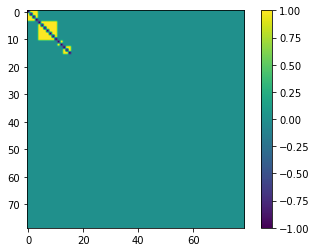

In [6]:
Qc = calc_penalty_term(M, lam=1.0)

plt.imshow(Qc)
plt.colorbar()
plt.show()

罰金項だけが表れているQUBO行列が確認できました。

### 献立データの学習

QUBO行列の更新は次式で行います。

$$
Q_{mn} = Q_{mn} - \eta\left( \frac{1}{N}\sum_{i=1}^N D_{im}D_{in} - \frac{1}{N^{\prime}} \sum_{i=1}^{N^{\prime}} x_{im}x_{in}\right)
$$

*   $D$：献立データ
*   $\mathbf{x}$：サンプル
*   $\frac{1}{N} \sum_{i=1}^{N} Z_{i m} Z_{i n}$：データに関する経験平均
*   $\frac{1}{N^{\prime}} \sum_{i=1}^{N^{\prime}} x_{i m} x_{i n}$：サンプルに関する経験平均
*   $\eta$：学習率

In [7]:
def train_model(Qc, D, eta, Tall, sampler, **sample_params):
    """
    Qc: QUBO行列(モデルの初期パラメータ)
    D: 献立データ
    eta: 学習率
    Tall: 学習回数
    sampler: サンプラー
    """

    # データに関する経験平均
    Dmat = np.dot(D.T, D)/len(D)

    Q = np.zeros(Qc.shape)
    for t in tqdm(np.arange(Tall)):
        Qmat = Q + Qc
        sampleset = sampler.sample_qubo(Qmat, **sample_params)
        x = sampleset.record.sample

        # サンプルに関する経験平均
        Xmat = np.dot(x.T, x)/len(x)

        # QUBO行列の更新
        Q -= eta*(Dmat-Xmat)

    return Qmat

これで、学習の準備が終わりました。献立の学習を行っていきましょう。

In [8]:
# SAの場合
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()

# D-Waveマシンの場合
# from dwave.system import DWaveCliqueSampler
# sampler = DWaveCliqueSampler(solver='', token='')

100%|██████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.39it/s]


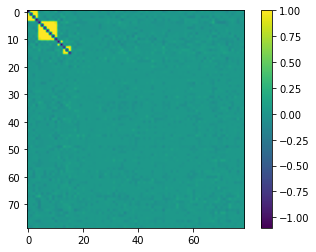

In [9]:
# MCMCの逆温度beta_rangeを設定
Qmat = train_model(Qc, D, eta=0.1, Tall=50, sampler=sampler, num_reads=100, beta_range=(32, 32))

plt.imshow(Qmat)
plt.colorbar()
plt.show()

### 使用する食材の提案
このQUBO行列を用いて、どのような解が得られるか見てみましょう。

In [10]:
# MCMCの逆温度beta_rangeを設定
sampleset = sampler.sample_qubo(Qmat, num_reads=50, beta_range=(32, 32)).aggregate()

得られた解から、罰金法の制約を見たす解のみ取り出します。

In [11]:
def extract_feasible_solution(sampleset):
    index_slices = [
        (0, 4),  # 主菜の調理方法
        (4, 11),  # 副菜の調理方法
        (11, 13),  # 汁物orデザート
        (13, 16)  # 主食(ごはん、麦ご飯、パン)
    ]

    feasible_indices = []
    for i, sample in enumerate(sampleset.record.sample):
        for b, e in index_slices:
            if np.sum(sample[b:e]) != 1:  # 実行可能解でない場合
                break
        else:
            feasible_indices.append(i)
    return sampleset.record.sample[feasible_indices]

In [12]:
ans = extract_feasible_solution(sampleset)
print(f'実行可能解の個数: {len(ans)}')

実行可能解の個数: 8


制約を見たす解を表示します。

In [14]:
df_ans = pd.DataFrame(data=ans, columns=df_data.columns)
df_ans.head()

,焼く,炒める,揚げる,煮る,生,焼く.1,炒める.1,揚げる.1,和える,煮る.1,...,きゅうり,キャベツ,とうもろこし,たまねぎ,えだまめ,きくらげ,グリンピース,じゃがいも,さつまいも,はるさめ
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1


## まとめ
このままでは何が作れるのか想像できません。次の記事では、ここで得られた解を自己組織化マップに投影することにより、実際に作れる料理まで提案する過程について解説します。

### 本記事の担当者
鹿内怜央